# A Two-Level, Six-Factor Full Factorial Design

<br />
<br />
<br />

### Table of Contents

* [Introduction](#intro)
* Factorial Experimental Design:
 * [Two-Level Six-Factor Full Factorial Design](#fullfactorial)
 * [Variables and Variable Labels](#varlabels)
 * [Computing Main and Interaction Effects](#computing_effects)
* Analysis of results:
 * [Analyzing Effects](#analyzing_effects)
 * [Quantile-Quantile Effects Plot](#quantile_effects)
 * [Utilizing Degrees of Freedom](#dof)
 * [Ordinary Least Squares Regression Model](#ols)
 * [Goodness of Fit](#goodness_of_fit)
 * [Distribution of Error](#distribution_of_error)
 * [Aggregating Results](#aggregating)
 * [Distribution of Variance](#dist_variance)
 * [Residual vs. Response Plots](#residual)

<br />
<br />
<br />


<a name="intro"></a>
## Introduction

This notebook roughly follows content from Box and Draper's _Empirical Model-Building and Response Surfaces_ (Wiley, 1984). This content is covered by Chapter 4 of Box and Draper.

In this notebook, we'll carry out an anaylsis of a full factorial design, and show how we can obtain inforomation about a system and its responses, and a quantifiable range of certainty about those values. This is the fundamental idea behind empirical model-building and allows us to construct cheap and simple models to represent complex, nonlinear systems.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy.random import rand, seed
import seaborn as sns
import scipy.stats as stats
from matplotlib.pyplot import *

seed(10)

<a name="fullfactorial"></a>
## Two-Level Six-Factor Full Factorial Design

Let's start with our six-factor factorial design example. Six factors means there are six input variables; this is still a two-level experiment, so this is now a $2^6$-factorial experiment.

Additionally, there are now three response variables, $(y_1, y_2, y_3)$. 

To generate a table of the 64 experiments to be run at each factor level, we will use the ```itertools.product``` function below. This is all put into a DataFrame.

This example generates some random response data, by multiplying a vector of random numbers by the vector of input variable values. (Nothing too complicated.)

In [2]:
import itertools

# Create the inputs:
encoded_inputs = list( itertools.product([-1,1],[-1,1],[-1,1],[-1,1],[-1,1],[-1,1]) )

# Create the experiment design table:
doe = pd.DataFrame(encoded_inputs,columns=['x%d'%(i+1) for i in range(6)])

In [3]:
# "Manufacture" observed data y
doe['y1'] = doe.apply( lambda z : sum([ rand()*z["x%d"%(i)]+0.01*(0.5-rand()) for i in range(1,7) ]), axis=1)
doe['y2'] = doe.apply( lambda z : sum([ 5*rand()*z["x%d"%(i)]+0.01*(0.5-rand()) for i in range(1,7) ]), axis=1)
doe['y3'] = doe.apply( lambda z : sum([ 100*rand()*z["x%d"%(i)]+0.01*(0.5-rand()) for i in range(1,7) ]), axis=1)
print(doe[['y1','y2','y3']])

          y1         y2          y3
0  -2.953976 -16.995589 -229.814820
1  -2.624777 -14.558143 -165.701057
2  -1.693929 -13.034991 -237.887785
3  -0.277497  -7.319593 -188.562237
4  -2.959396 -16.067548 -243.198515
5  -1.385948  -4.418310  -97.470198
6  -0.651712  -1.928300  -73.312885
7  -0.278417   2.396784  -62.784436
8  -2.153633  -7.975643 -136.147108
9   0.759198  -4.809812   -0.699339
10  0.394272  -9.209924  -53.132653
11  0.522598   1.005940  -29.222722
12 -0.196592  -5.636971 -134.246284
13 -0.788804   0.064581  -56.366364
14 -0.109515   2.584266  -30.826161
15  0.857284   4.937100  162.478927
16 -1.717446  -9.544005 -278.879535
17 -0.377420  -5.952183  -85.342715
18  0.235274  -3.912253  -84.515613
19 -0.438223   4.263438  -15.766010
20 -0.719210  -6.169082  -38.400881
21  0.874268  -0.500338   24.659802
22  0.287457   3.135320   -8.054772
23  1.516798   1.067475   49.077046
24 -1.553102  -2.767240 -121.753634
25  0.464493   6.216963  -72.732938
26  1.043009   0.026061  151

<a name="varlablels"></a>
## Defining Variables and Variable Labels

Next we'll define some containers for input variable labels, output variable labels, and any interaction terms that we'll be computing:

In [4]:
labels = {}
labels[1] = ['x1','x2','x3','x4','x5','x6']
for i in [2,3,4,5,6]:
    labels[i] = list(itertools.combinations(labels[1], i))

obs_list = ['y1','y2','y3']

for k in labels.keys():
    print(str(k) + " : " + str(labels[k]))

1 : ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
2 : [('x1', 'x2'), ('x1', 'x3'), ('x1', 'x4'), ('x1', 'x5'), ('x1', 'x6'), ('x2', 'x3'), ('x2', 'x4'), ('x2', 'x5'), ('x2', 'x6'), ('x3', 'x4'), ('x3', 'x5'), ('x3', 'x6'), ('x4', 'x5'), ('x4', 'x6'), ('x5', 'x6')]
3 : [('x1', 'x2', 'x3'), ('x1', 'x2', 'x4'), ('x1', 'x2', 'x5'), ('x1', 'x2', 'x6'), ('x1', 'x3', 'x4'), ('x1', 'x3', 'x5'), ('x1', 'x3', 'x6'), ('x1', 'x4', 'x5'), ('x1', 'x4', 'x6'), ('x1', 'x5', 'x6'), ('x2', 'x3', 'x4'), ('x2', 'x3', 'x5'), ('x2', 'x3', 'x6'), ('x2', 'x4', 'x5'), ('x2', 'x4', 'x6'), ('x2', 'x5', 'x6'), ('x3', 'x4', 'x5'), ('x3', 'x4', 'x6'), ('x3', 'x5', 'x6'), ('x4', 'x5', 'x6')]
4 : [('x1', 'x2', 'x3', 'x4'), ('x1', 'x2', 'x3', 'x5'), ('x1', 'x2', 'x3', 'x6'), ('x1', 'x2', 'x4', 'x5'), ('x1', 'x2', 'x4', 'x6'), ('x1', 'x2', 'x5', 'x6'), ('x1', 'x3', 'x4', 'x5'), ('x1', 'x3', 'x4', 'x6'), ('x1', 'x3', 'x5', 'x6'), ('x1', 'x4', 'x5', 'x6'), ('x2', 'x3', 'x4', 'x5'), ('x2', 'x3', 'x4', 'x6'), ('x2', 'x3', 'x5', 'x6

Now that we have variable labels for each main effect and interaction effect, we can actually compute those effects.

<a name="computing_effects"></a>
## Computing Main and Interaction Effects

We'll start by finding the constant effect, which is the mean of each response:

In [5]:
effects = {}

# Start with the constant effect: this is $\overline{y}$
effects[0] = {'x0' : [doe['y1'].mean(),doe['y2'].mean(),doe['y3'].mean()]}
print(effects[0])

{'x0': [0.21434217402141204, -0.34071899604049039, -0.31091988519642655]}


Next, compute the main effect of each variable, which quantifies the amount the response changes by when the input variable is changed from the -1 to +1 level. That is, it computes the average effect of an input variable $x_i$ on each of the three response variables $y_1, y_2, y_3$.

In [6]:
effects[1] = {}
for key in labels[1]:
    effects_result = []
    for obs in obs_list:
        effects_df = doe.groupby(key)[obs].mean()
        result = sum([ zz*effects_df.ix[zz] for zz in effects_df.index ])
        effects_result.append(result)
    effects[1][key] = effects_result

effects[1]

{'x1': [0.9433070339050128, 4.9958304988566571, 81.100835834869898],
 'x2': [1.1618193437509752, 5.2904519800700855, 88.974507036059862],
 'x3': [1.0098728146371736, 5.889504208769762, 117.98004192024942],
 'x4': [0.70708531571387601, 4.3129802767035228, 93.841283759812427],
 'x5': [0.73764230931195218, 5.9194227362518177, 80.560308830542212],
 'x6': [0.90984137041079882, 5.3509498773330124, 85.074447049008739]}

Our next step is to crank through each variable interaction level: two-variable, three-variable, and on up to six-variable interaction effects. We compute interaction effects for each two-variable combination, three-variable combination, etc.

In [7]:
for c in [2,3,4,5,6]:
    effects[c] = {}
    for key in labels[c]:
        effects_result = []
        for obs in obs_list:
            effects_df = doe.groupby(key)[obs].mean()
            result = sum([ np.prod(zz)*effects_df.ix[zz]/(2**(len(zz)-1)) for zz in effects_df.index ])
            effects_result.append(result)
        effects[c][key] = effects_result

In [8]:
def printd(d):
    for k in d.keys():
        print("%25s : %s"%(k,d[k]))

for i in range(1,7):
    printd(effects[i])


                       x1 : [0.9433070339050128, 4.9958304988566571, 81.100835834869898]
                       x2 : [1.1618193437509752, 5.2904519800700855, 88.974507036059862]
                       x3 : [1.0098728146371736, 5.889504208769762, 117.98004192024942]
                       x4 : [0.70708531571387601, 4.3129802767035228, 93.841283759812427]
                       x5 : [0.73764230931195218, 5.9194227362518177, 80.560308830542212]
                       x6 : [0.90984137041079882, 5.3509498773330124, 85.074447049008739]
             ('x1', 'x2') : [-0.016163435253460867, -0.403048707291632, -26.414521929296882]
             ('x1', 'x3') : [-0.12102391162066295, 0.37460806899997978, -17.291608673837352]
             ('x1', 'x4') : [0.02949032440056043, 0.33911161905856435, 12.403992911833804]
             ('x1', 'x5') : [-0.50925949665219905, -0.019045678054248061, -26.947410571506602]
             ('x1', 'x6') : [0.094773221600433111, -0.24795908645176201, -5.7366788045510191

We've computed the main and interaction effects for every variable combination (whew!), but now we're at a point where we want to start doing things with these quantities.

<a name="analyzing_effects"></a>
## Analyzing Effects

The first and most important question is, what variable, or combination of variables, has the strongest effect on the three responses $y_1$? $y_2$? $y_3$?

To figure this out, we'll need to use the data we computed above. Python makes it easy to slice and dice data. In this case, we've constructed a nested dictionary, with the outer keys mapping to the number of variables and inner keys mapping to particular combinations of input variables. Its pretty easy to convert this to a flat data structure that we can use to sort by variable effects. We've got six "levels" of variable combinations, so we'll flatten ```effects``` by looping through all six dictionaries of variable combinations (from main effects to six-variable interaction effects), and adding each entry to a master dictionary.

The master dictionary will be a flat dictionary, and once we've populated it, we can use it to make a DataFrame for easier sorting, printing, manipulating, aggregating, and so on.

In [9]:
print(len(effects))

7


In [10]:
master_dict = {}
for nvars in effects.keys():

    effect = effects[nvars]
    for k in effect.keys():
        v = effect[k]
        master_dict[k] = v

master_df = pd.DataFrame(master_dict).T
master_df.columns = obs_list

In [11]:
y1 = master_df['y1'].copy()
y1.sort_values(inplace=True,ascending=False)

print("Top 10 effects for observable y1:")
print(y1[:10])

Top 10 effects for observable y1:
x2                  1.161819
x3                  1.009873
x1                  0.943307
x6                  0.909841
x5                  0.737642
x4                  0.707085
(x1, x5, x6)        0.364434
(x1, x2, x5, x6)    0.292660
(x1, x2, x3)        0.275302
(x1, x3, x6)        0.214889
Name: y1, dtype: float64


In [12]:
y2 = master_df['y2'].copy()
y2.sort_values(inplace=True,ascending=False)

print("Top 10 effects for observable y2:")
print(y2[:10])

Top 10 effects for observable y2:
x5                  5.919423
x3                  5.889504
x6                  5.350950
x2                  5.290452
x1                  4.995830
x4                  4.312980
(x1, x2, x4, x5)    1.750702
(x1, x2, x3)        1.733954
(x1, x2, x4)        1.732308
(x1, x3, x4)        1.549314
Name: y2, dtype: float64


In [13]:
y3 = master_df['y3'].copy()
y3.sort_values(inplace=True,ascending=False)

print("Top 10 effects for observable y3:")
print(y3[:10])


Top 10 effects for observable y3:
x3                          117.980042
x4                           93.841284
x2                           88.974507
x6                           85.074447
x1                           81.100836
x5                           80.560309
(x1, x2, x3, x4, x5, x6)     36.787280
(x3, x5, x6)                 26.955452
(x1, x5, x6)                 26.314820
(x1, x3, x5, x6)             23.832389
Name: y3, dtype: float64


If we were only to look at the list of rankings of each variable, we would see that each response is affected by different input variables, listed below in order of descending importance:
* $y_1$: 136254
* $y_2$: 561234
* $y_3$: 453216

This is a somewhat mixed message that's hard to interpret - can we get rid of variable 2? We can't eliminate 1, 4, or 5, and probably not 3 or 6 either. 

However, looking at the quantile-quantile plot of the effects answers the question in a more visual way.

<a name="quantile_effects"></a>
## Quantile-Quantile Effects Plot

We can examine the distribution of the various input variable effects using a quantile-quantile plot of the effects. Quantile-quantile plots arrange the effects in order from least to greatest, and can be applied in several contexts (as we'll see below, when assessing model fits). If the quantities plotted on a quantile-qantile plot are normally distributed, they will fall on a straight line; data that do not fall on the straight line indicate significant deviations from normal behavior.

In the case of a quantile-quantile plot of effects, non-normal behavior means the effect is paticularly strong. By identifying the outlier points on thse quantile-quantile plots (they're ranked in order, so they correspond to the lists printed above), we can identify the input variables most likely to have a strong impact on the responses.

We need to look both at the top (the variables that have the largest overall positive effect) and the bottom (the variables that have the largest overall negative effect) for significant outliers. When we find outliers, we can add them to a list of variabls that we have decided are important and will keep in our analysis.

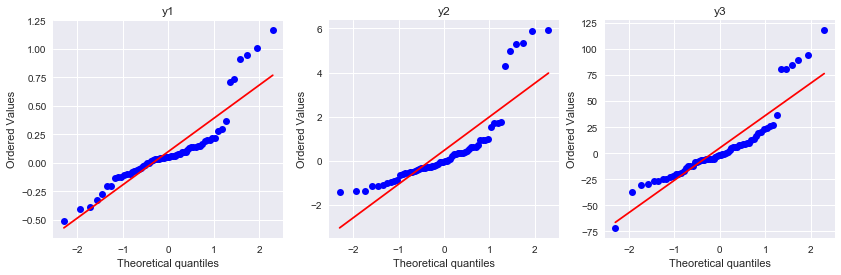

In [14]:
# Quantify which effects are not normally distributed, 
# to assist in identifying important variables

fig = figure(figsize=(14,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

stats.probplot(y1, dist="norm", plot=ax1)
ax1.set_title('y1')

stats.probplot(y2, dist="norm", plot=ax2)
ax2.set_title('y2')

stats.probplot(y3, dist="norm", plot=ax3)
ax3.set_title('y3')

Normally, we would use the main effects that were computed, and their rankings, to eliminate any variables that don't have a strong effect on any of our variables. However, this analysis shows that sometimes we can't eliminate any variables.

All six input variables are depicted as the effects that fall far from the red line - indicating all have a statistically meaningful (i.e., not normally distributed) effect on all three response variables. This means we should keep all six factors in our analysis.

There is also a point on the $y_3$ graph that appears significant on the bottom. Examining the output of the lists above, this point represents the effect for the six-way interaction of all input variables. High-order interactions are highly unlikely (and in this case it is a numerical artifact of the way the responses were generated), so we'll keep things simple and stick to a linear model.

Let's continue our analysis without eliminating any of the six factors, since they are important to all of our responses.

<a name="dof"></a>
## Utilizing Degrees of Freedom

Our very expensive, 64-experiment full factorial design (the data for which maps $(x_1,x_2,\dots,x_6)$ to $(y_1,y_2,y_3)$) gives us 64 data points, and 64 degrees of freedom. What we do with those 64 degrees of freedom is up to us.

We _could_ fit an empirical model, or response surface, that has 64 independent parameters, and account for many of the high-order interaction terms - all the way up to six-variable interaction effects. However, high-order effects are rarely important, and are a waste of our degrees of freedom.

Alternatively, we can fit an empirical model with fewer coefficients, using up fewer degrees of freedom, and use the remaining degrees of freedom to characterize the error introduced by our approximate model.

To describe a model with the 6 variables listed above and no other variable interaction effects would use only 6 degrees of freedom, plus 1 degree of freedom for the constant term, leaving 57 degrees of freedom available to quantify error, attribute variance, etc.

Our goal is to use least squares to compute model equations for $(y_1,y_2,y_3)$ as functions of $(x_1,x_2,x_3,x_4,x_5,x_6)$. 

In [15]:
xlabs = ['x1','x2','x3','x4','x5','x6']
ylabs = ['y1','y2','y3']
ls_data = doe[xlabs+ylabs]

In [16]:
import statsmodels.api as sm
import numpy as np

x = ls_data[xlabs]
x = sm.add_constant(x)

The first ordinary least squares linear model is created to predict values of the first variable, $y_1$, as a function of each of our input variables, the list of which are contained in the ```xlabs``` variable. When we perform the linear regression fitting, we see much of the same information that we found in the prior two-level three-factor full factorial design, but here, everything is done automatically.

The model is linear, meaning it's fitting the coefficients of the function:

$$
\hat{y} = a_0 + a_1 x_1 + a_2 x_2 + a_3 + x_3 + a_4 x_4 + a_5 x_5 + a_6 x_6
$$

(here, the variables $y$ and $x$ are vectors, with one component for each response; in our case, they are three-dimensional vectors.) 

Because there are 64 observations and 7 coefficients, the 57 extra observations give us extra degrees of freedom with which to assess how good the model is. That analysis can be done with an ordinary least squares (OLS) model, available through the statsmodel library in Python. 

<a name="ols"></a>
## Ordinary Least Squares Regression Model

This built-in OLS model will fit an input vector $(x_1,x_2,x_3,x_4,x_5,x_6)$ to an output vector $(y_1,y_2,y_3)$ using a linear model; the OLS model is designed to fit the model with more observations than coefficients, and utilize the remaining data to quantify the fit of the model.

Let's run through one of these, and analyze the results:

In [17]:
y1 = ls_data['y1']
est1 = sm.OLS(y1,x).fit()
print(est1.summary())

                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     29.96
Date:                Tue, 27 Jun 2017   Prob (F-statistic):           6.28e-16
Time:                        18:45:41   Log-Likelihood:                -62.028
No. Observations:                  64   AIC:                             138.1
Df Residuals:                      57   BIC:                             153.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2143      0.084      2.537      0.0

The StatsModel OLS object prints out quite a bit of useful information, in a nicely-formatted table. Starting at the top, we see a couple of important pieces of information: specifically, the name of the dependent variable (the response) that we're looking at, the number of observations, and the number of degrees of freedom. 

We can see an $R^2$ statistic, which indicates how well this data is fit with our linear model, and an adjusted $R^2$ statistic, which accounts for the large nubmer of degrees of freedom. While an adjusted $R^2$ of 0.73 is not great, we have to remember that this linear model is trying to capture a wealth of complexity in six coefficients. Furthermore, the adjusted $R^2$ value is too broad to sum up how good our model actually is.

The table in the middle is where the most useful information is located. The `coef` column shows the coefficients $a_0, a_1, a_2, \dots$ for the model equation:

$$
\hat{y} = a_0 + a_1 x_1 + a_2 x_2 + a_3 + x_3 + a_4 x_4 + a_5 x_5 + a_6 x_6
$$

Using the extra degrees of freedom, an estime $s^2$ of the variance in the regression coefficients is also computed, and reported in the the `std err` column. Each linear term is attributed the same amount of variance, $\pm 0.082$.

In [18]:
y2 = ls_data['y2']
est2 = sm.OLS(y2,x).fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     47.06
Date:                Tue, 27 Jun 2017   Prob (F-statistic):           2.61e-20
Time:                        18:45:41   Log-Likelihood:                -159.57
No. Observations:                  64   AIC:                             333.1
Df Residuals:                      57   BIC:                             348.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3407      0.388     -0.878      0.3

In [19]:
y3 = ls_data['y3']
est3 = sm.OLS(y3,x).fit()
print(est3.summary())

                            OLS Regression Results                            
Dep. Variable:                     y3   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     23.72
Date:                Tue, 27 Jun 2017   Prob (F-statistic):           7.57e-14
Time:                        18:45:41   Log-Likelihood:                -364.01
No. Observations:                  64   AIC:                             742.0
Df Residuals:                      57   BIC:                             757.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3109      9.461     -0.033      0.9

<a name="goodness_of_fit"></a>
## Quantifying Model Goodness-of-Fit

We can now use these linear models to evaluate each set of inputs and compare the model response $\hat{y}$ to the actual observed response $y$. What we would expect to see, if our model does an adequate job of representing the underlying behavior of the model, is that in each of the 64 experiments, the difference between the model prediction $M$ and the measured data $d$, defined as the residual $r$,

$$
r = \left| d - M \right|
$$

should be comparable across all experiments. If the residuals appear to have functional dependence on the input variables, it is an indication that our model is missing important effects and needs more or different terms. The way we determine this, mathematically, is by looking at a quantile-quantile plot of our errors (that is, a ranked plot of our error magnitudes). 

If the residuals are normally distributed, they will follow a straight line; if the plot shows the data have significant wiggle and do not follow a line, it is an indication that the errors are not normally distributed, and are therefore skewed (indicating terms missing from our OLS model).

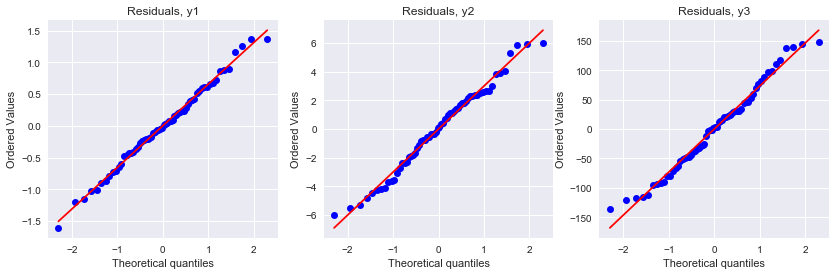

In [20]:
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from matplotlib.pyplot import *

# Quantify goodness of fit

fig = figure(figsize=(14,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

r1 = y1 - est1.predict(x)
r2 = y2 - est2.predict(x)
r3 = y3 - est3.predict(x)

stats.probplot(r1, dist="norm", plot=ax1)
ax1.set_title('Residuals, y1')

stats.probplot(r2, dist="norm", plot=ax2)
ax2.set_title('Residuals, y2')

stats.probplot(r3, dist="norm", plot=ax3)
ax3.set_title('Residuals, y3')


Determining whether significant trends are being missed by the model depends on how many points deviate from the red line, and how significantly. If there is a single point that deviates, it does not necessarily indicate a problem; but if there is significant wiggle and most points deviate significantly from the red line, it means that there is something about the relationship between the inputs and the outputs that our model is missing.

There are only a few points deviating from the red line. We saw from the effect quantile for $y_3$ that there was an interaction variable that was important to modeling the response $y_3$, and it is likely this interaction that is leading to noise at the tail end of these residuals. This indicates residual errors (deviations of the model from data) that do not follow a natural, normal distribution, which indicates there is a _pattern_ in the deviations - namely, the interaction effect.

The conclusion about the error from the quantile plots above is that there are only a few points deviation from the line, and no particularly significant outliers. Our model can use some improvement, but it's a pretty good first-pass model.

<a name="distribution_of_error"></a>
## Distribution of Error

Another thing we can look at is the normalized error: what are the residual errors (differences between our model prediction and our data)? How are their values distributed? 

A kernel density estimate (KDE) plot, which is a smoothed histogram, shows the probability distribution of the normalized residual errors. As expected, they're bunched pretty close to zero. There are some bumps far from zero, corresponding to the outliers on the quantile-quantile plot of the errors above. However, they're pretty close to randomly distributed, and therefore it doesn't look like there is any systemic bias there.

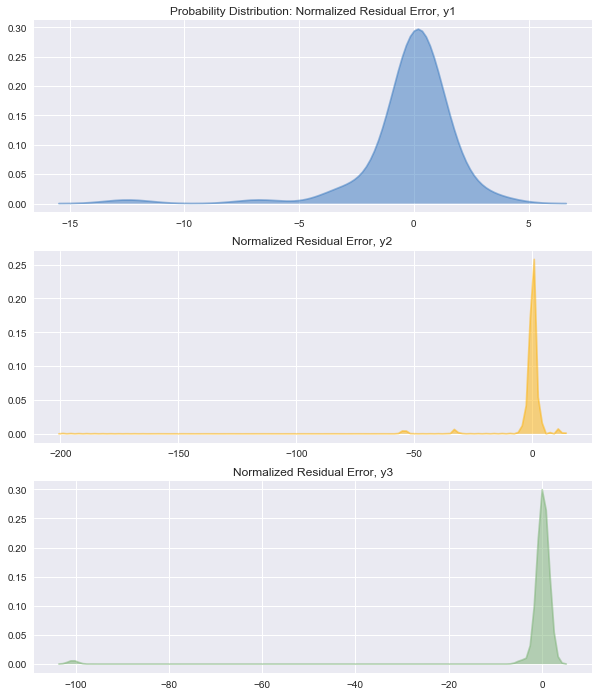

In [21]:
fig = figure(figsize=(10,12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
axes = [ax1,ax2,ax3]

colors = sns.xkcd_palette(["windows blue", "amber", "faded green", "dusty purple","aqua blue"])

#resids = [r1, r2, r3]
normed_resids = [r1/y1, r2/y2, r3/y3]

for (dataa, axx, colorr) in zip(normed_resids,axes,colors):
    sns.kdeplot(dataa, bw=1.0, ax=axx, color=colorr, shade=True, alpha=0.5);

ax1.set_title('Probability Distribution: Normalized Residual Error, y1')
ax2.set_title('Normalized Residual Error, y2')
ax3.set_title('Normalized Residual Error, y3')


Note that in these figures, the bumps at extreme value are caused by the fact that the interval containing the responses includes 0 and values close to 0, so the normalization factor is very tiny, leading to large values.

<a name="aggregating"></a>
## Aggregating Results

Let's next aggregate experimental results, by taking the mean over various variables to compute the mean effect for regressed varables. For example, we may want to look at the effects of variables 2, 3, and 4, and take the mean over the other three variables.

This is simple to do with Pandas, by grouping the data by each variable, and applying the mean function on all of the results. The code looks like this:

In [22]:
# Our original regression variables
xlabs = ['x2','x3','x4']
doe.groupby(xlabs)[ylabs].mean()

y1        y2          y3
x2 x3 x4                                
-1 -1 -1 -1.312180 -8.231421 -158.966973
       1 -0.538437 -2.991776  -42.718649
    1 -1 -0.153627 -3.200942  -36.608578
       1  0.537974  2.480359   59.101506
 1 -1 -1  0.021285 -2.700483  -53.775986
       1  0.666955  0.781796   18.257844
    1 -1  0.887720  4.144010   60.425290
       1  1.605047  6.992705  151.798186

In [23]:
# If we decided to go for a different variable set
xlabs = ['x2','x3','x4','x6']
doe.groupby(xlabs)[ylabs].mean()

y1         y2          y3
x2 x3 x4 x6                                 
-1 -1 -1 -1 -1.467098 -11.634463 -177.465836
          1 -1.157263  -4.828380 -140.468110
       1 -1 -1.124934  -4.519789  -90.787481
          1  0.048060  -1.463762    5.350184
    1 -1 -1 -0.901130  -6.008022  -53.864545
          1  0.593876  -0.393863  -19.352612
       1 -1  0.285655   0.099799   -9.012942
          1  0.790293   4.860920  127.215955
 1 -1 -1 -1 -0.231442  -5.478294  -92.851874
          1  0.274012   0.077328  -14.700099
       1 -1  0.105898  -0.728904  -39.621122
          1  1.228013   2.292495   76.136811
    1 -1 -1  0.318023   0.177202    5.502191
          1  1.457417   8.110817  115.348390
       1 -1  1.090399   3.962919  115.316461
          1  2.119695  10.022492  188.279910

This functionality can also be used to determine the variance in all of the experimental observations being aggregated. For example, here we aggregate over $x_3 \dots x_6$ and show the variance broken down by $x_1, x_2$ vs $y_1, y_2, y_3$.

In [24]:
xlabs = ['x1','x2']
doe.groupby(xlabs)[ylabs].var()

y1         y2            y3
x1 x2                                   
-1 -1  1.688944  48.644180  11048.732564
    1  1.144894  27.506487  20550.899895
 1 -1  0.992189  33.485163  15883.558781
    1  0.993779  51.531576  12424.563466

Or even the number of experimental observations being aggregated!

In [25]:
doe.groupby(xlabs)[ylabs].count()

y1  y2  y3
x1 x2            
-1 -1  16  16  16
    1  16  16  16
 1 -1  16  16  16
    1  16  16  16

<a name="dist_variance"></a>
## Distributions of Variance

We can convert these dataframes of averages, variances, and counts into data for plotting. For example, if we want to make a histogram of every value in the groupby dataframe, we can use the ```.values``` method, so that this:

    doe.gorupby(xlabs)[ylabs].mean()

becomes this:


    doe.groupby(xlabs)[ylabs].mean().values


This $M \times N$ array can then be flattened into a vector using the ```ravel()``` method from numpy:

    np.ravel( doe.groupby(xlabs)[ylabs].mean().values )

The resulting data can be used to generate histograms, as shown below:

Grouping responses by x1-x2-x3-x4


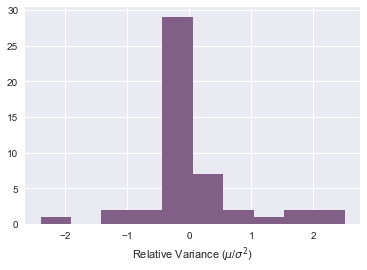

In [26]:
# Histogram of means of response values, grouped by xlabs

xlabs = ['x1','x2','x3','x4']

print("Grouping responses by %s"%( "-".join(xlabs) ))

dat = np.ravel(doe.groupby(xlabs)[ylabs].mean().values) / np.ravel(doe.groupby(xlabs)[ylabs].var().values)

hist(dat, 10, normed=False, color=colors[3]);
xlabel(r'Relative Variance ($\mu$/$\sigma^2$)')
show()

Grouping responses by x1-x2-x3-x4


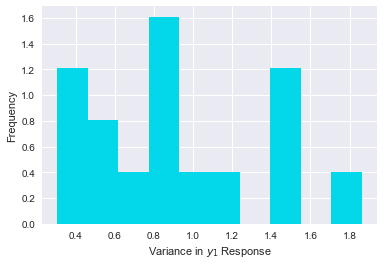

In [27]:
# Histogram of variances of response values, grouped by xlabs

print("Grouping responses by %s"%( "-".join(xlabs) ))

dat = np.ravel(doe.groupby(xlabs)['y1'].var().values)

hist(dat, normed=True, color=colors[4])
xlabel(r'Variance in $y_{1}$ Response')
ylabel(r'Frequency')
show()

The distribution of variance looks _mostly_ normal, with some outliers. These are the same outliers that showed up in our quantile-quantile plot, and they'll show up in the plots below as well.

<a name="residual"></a>
## Residual vs. Response Plots

Another thing we can do, to look for uncaptured effects, is to look at our residuals vs. $\hat{y}$. This is a further effort to look for underlying functional relationships between $\hat{y}$ and the residuals, which would indicate that our system exhibits behavior not captured by our linear model.

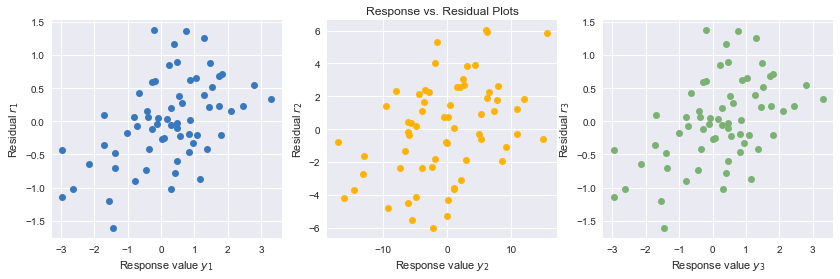

In [28]:
# normal plot of residuals

fig = figure(figsize=(14,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.plot(y1,r1,'o',color=colors[0])
ax1.set_xlabel('Response value $y_1$')
ax1.set_ylabel('Residual $r_1$')

ax2.plot(y2,r2,'o',color=colors[1])
ax2.set_xlabel('Response value $y_2$')
ax2.set_ylabel('Residual $r_2$')
ax2.set_title('Response vs. Residual Plots')

ax3.plot(y1,r1,'o',color=colors[2])
ax3.set_xlabel('Response value $y_3$')
ax3.set_ylabel('Residual $r_3$')

show()

Notice that each plot is trending up and to the right - indicative of an underlying trend that our model $\hat{y}$ is not capturing. The trend is relatively weak, however, indicating that our linear model does a good job of capturing _most_ of the relevant effects of this system.

# Discussion 

The analysis shows that there are some higher-order or nonlinear effects in the system that a purely linear model does not account for. Next steps would involve adding higher order points for a quadratic or higher order polynomial model to gather additional data to fit the higher-degree models.